## assignment 04: Decision Tree construction

In [ ]:
# If working in colab, uncomment the following line
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/assignment0_04_tree/tree.py -nc

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target_boston = raw_df.values[1::2, 2]

%load_ext autoreload
%autoreload 2

Let's fix the `random_state` (a.k.a. random seed).

In [2]:
RANDOM_STATE = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

### Check yourself

In [3]:
from tree import entropy, gini, variance, mad_median, DecisionTree

#### Simple check

In [4]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [5]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [6]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [7]:
y_train.shape

(1437, 1)

In [8]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)

In [9]:
class_estimator.depth

10

In [10]:
ans = class_estimator.predict(X_test)

In [11]:
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8638888888888889


In [12]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [13]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8805555555555555


In [14]:
class_estimator.depth

10

In [15]:
assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9

In [16]:
np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0))) -np.sum(reference)

1.1102230246251565e-16

In [17]:
np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference))

0.024999993333333317

In [18]:
assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-4

AssertionError: 

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [19]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [20]:
%%time
gs.fit(X_train, y_train)

/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:42: RuntimeWarning: invalid value encountered in divide
  p = np.sum(y, axis=0) / y.shape[0]
/home/evgen/mlcourse/ml-cour

CPU times: user 53.4 s, sys: 190 ms, total: 53.6 s
Wall time: 31min 12s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

In [21]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 8}

In [22]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

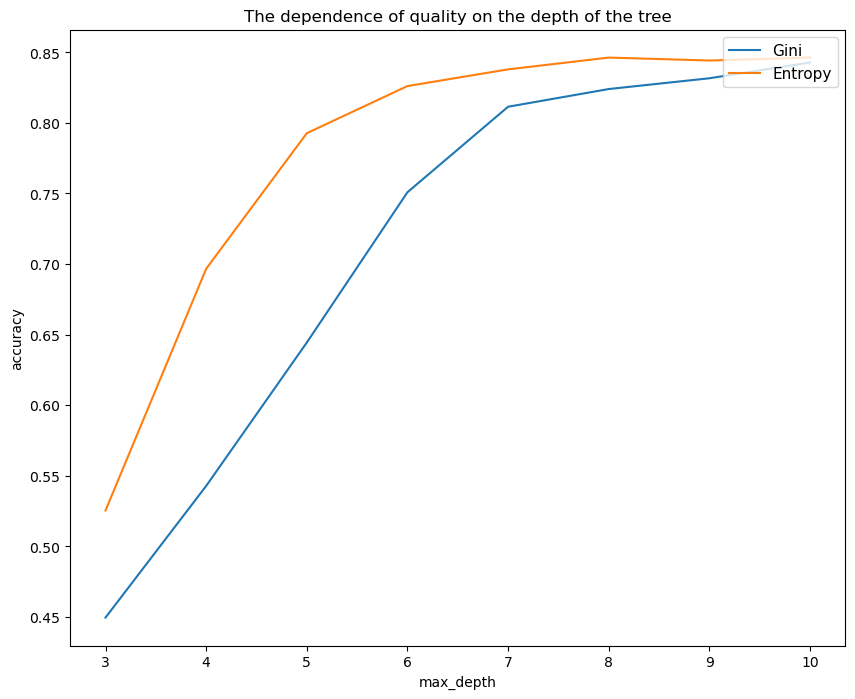

In [23]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [24]:
regr_data = data_boston
regr_target = target_boston[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

In [25]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


19.70720588235294


In [26]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


10.322185651177042


In [27]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [28]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [29]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:62: RuntimeWarning: invalid value encountered in scalar divide
  variance = np.sum((y - np.mean(y, axis=0))**2) / np.shape(y)[0]
/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/evgen/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/evgen/mlcourse/ml-course/homeworks/assignment0_04_tree/tree.py:62: RuntimeWarning: invalid value encountered in scalar divide
  variance = np.su

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [30]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 5}

In [31]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [32]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

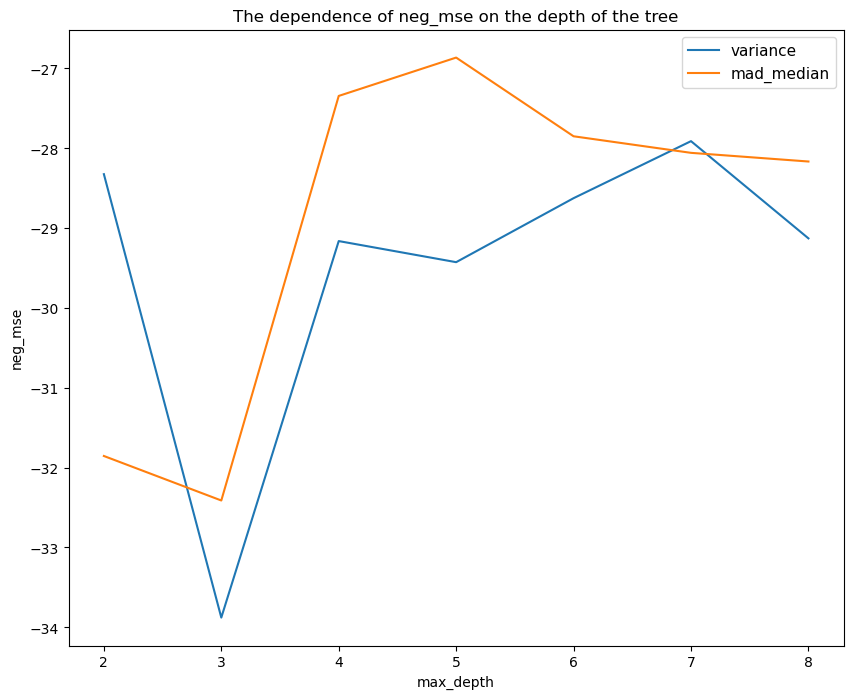

In [33]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()

In [37]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [38]:
from sklearn.tree import DecisionTreeClassifier


In [39]:
%%time
est = DecisionTreeClassifier(max_depth=10)
est.fit(X_train, y_train)

CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 28.3 ms


DecisionTreeClassifier(max_depth=10)

In [40]:
%%time
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)

CPU times: user 1min 1s, sys: 48.9 ms, total: 1min 1s
Wall time: 1min 1s


In [42]:
pred_sk = est.predict(X_test)
pred_my = class_estimator.predict(X_test)
score_sk = accuracy_score(y_test, pred_sk)
score_my = accuracy_score(y_test, pred_my)
print(f'my score: {score_my}, sklearn score: {score_sk}')

my score: 0.8638888888888889, sklearn score: 0.8527777777777777


In [43]:
proba_sk = est.predict_proba(X_test)
proba_my = class_estimator.predict_proba(X_test)
np.sum(np.abs(proba_my.mean(axis=0) - proba_sk.mean(axis=0)))

0.05883597883597888

In [44]:
proba_my.mean(axis=0)

array([0.08333333, 0.06686974, 0.08417747, 0.10430919, 0.14112254,
       0.13835125, 0.11481481, 0.09545234, 0.06902739, 0.10254192])

In [45]:
proba_sk.mean(axis=0)

array([0.08055556, 0.07149937, 0.08028858, 0.10430919, 0.141731  ,
       0.14112903, 0.09537037, 0.10722483, 0.07865702, 0.09923505])